In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ddm
import os 
import csv
from model_definitions import ModelTtaBounds

import paranoid as pns
pns.settings.Settings.set(enabled=False)

In [5]:
def get_model_measures(model, condition):
#     print(condition)
    sol = model.solve(condition)
    return condition['tta_condition'], condition['d_condition'], sol.prob_correct(), sol.mean_decision_time()

def simulate_model(ndt, param_set, conditions): 
    overlay = (ddm.OverlayNonDecisionUniform(nondectime=param_set.nondectime,
                                            halfwidth=param_set.halfwidth) 
                if ndt=='uniform' else 
               ModelTtaBounds.OverlayNonDecisionGaussian(nondectime=param_set.ndt_location,
                                                       ndsigma=param_set.ndt_scale))

    model = ddm.Model(name='5 TTA- and d-dependent drift and bounds and random nondecision time',
                         drift=ModelTtaBounds.DriftTtaDistance(alpha=param_set.alpha, 
                                                               beta=param_set.beta, theta=param_set.theta),
                         noise=ddm.NoiseConstant(noise=param_set.noise),
                         bound=ModelTtaBounds.BoundCollapsingTta(b_0=param_set.b_0, 
                                                                 k=param_set.k, tta_crit=param_set.tta_crit),
                         overlay=overlay, T_dur=ModelTtaBounds.T_dur)
    model_measures = pd.DataFrame([get_model_measures(model, condition) for condition in conditions],
                                  columns=['tta_condition', 'd_condition', 'is_turn_decision', 'RT'])
    model_measures['subj_id'] = param_set.subj_id
    
#     model_rt_histograms = pd.DataFrame({'tta_condition': condition['tta_condition'],
#                                         'd_condition':  condition['d_condition'],
#                                         't': model.t_domain(),
#                                         'rt_corr_pdf': sol.pdf_corr()/sol.prob_correct()})
    return(model_measures)

In [6]:
def save_sim_results(ndt, file_name):
    exp_data = pd.read_csv('../data/measures.csv', usecols=['subj_id', 'RT', 'is_turn_decision', 
                                                    'tta_condition', 'd_condition'])
    subjects = exp_data.subj_id.unique()
    conditions = [{'tta_condition': tta, 'd_condition': d} 
                   for tta in exp_data.tta_condition.unique() 
                   for d in exp_data.d_condition.unique()]

    path = '../model_fit_results/%s_ndt' % (ndt)
    file_path = os.path.join(path, file_name)
    parameters = pd.read_csv(file_path).rename(columns={'tta': 'tta_condition', 'd': 'd_condition'})
    
    if ('cross_validation' in file_name):
#         print([param_set[['tta_condition', 'd_condition']].to_dict() for idx, param_set in parameters.iterrows()])
#         for cross-validated fits, we need to read conditions from params
        sim_results = [simulate_model(ndt, param_set, [param_set[['tta_condition', 'd_condition']].to_dict()]) 
                       for idx, param_set in parameters.iterrows()]
    else:
        # for the uniform ndt fits, multiple runs were performed per subject; only leave the best iteration
        if ((ndt=='uniform') & (len(parameters.i.unique())>1)): 
            idx_best_fit = parameters['loss'] == parameters.groupby(['subj_id'])['loss'].transform(max)
            parameters = parameters[idx_best_fit]
        sim_results = [simulate_model(ndt, param_set, conditions) for idx, param_set in parameters.iterrows()]
    
    sim_results = pd.concat(sim_results)
    sim_results.to_csv(file_path.replace('merged', 'measures'), index=False)

In [6]:
save_sim_results('gaussian', 'all_conditions_merged.csv')

In [7]:
save_sim_results('gaussian', 'cross_validation_and_merged.csv')

In [8]:
save_sim_results('gaussian', 'cross_validation_or_merged.csv')

In [14]:
save_sim_results('uniform', 'all_conditions_merged.csv')

In [67]:
save_sim_results('uniform', 'cross_validation_4_merged.csv')

In [68]:
save_sim_results('uniform', 'cross_validation_8_merged.csv')

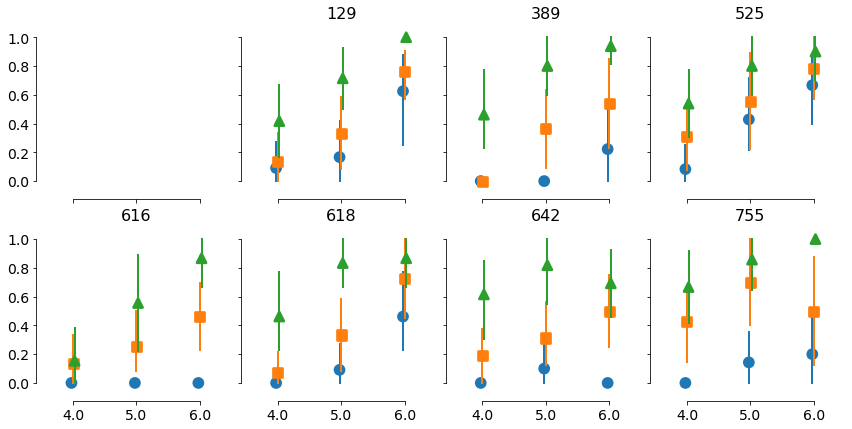

In [53]:
var = 'is_turn_decision'
data = exp_data

fig, axes = plt.subplots(2, 4, figsize=(12,6), sharex=True, sharey=True)

for subj_id, ax in zip(subjects, axes.flatten()[1:]):
    ax.set_title(subj_id, fontsize=16)
    if not ((subj_id == 616) & (var=='RT')):
        sns.pointplot(ax=ax, data=data[data.subj_id==subj_id], 
                  x='tta_condition', y=var, hue='d_condition', join=False, dodge=0.05,
                  markers=['o', 's', '^'], scale=1, errwidth=2)
    else:
        sns.pointplot(ax=ax, data=data[data.subj_id==subj_id], 
                  x='tta_condition', y=var, hue='d_condition', join=False, dodge=0.05,
                  markers=['s', '^'], palette=['C1', 'C2'], scale=1, errwidth=2)

#     subj_fit_results_path = os.path.join(fit_results_path, str(subj_id))
#     subj_model_measures = pd.read_csv(os.path.join(subj_fit_results_path, 'measures.csv'))
    for d_condition, marker in zip(d_conditions, ['o', 's', '^']):
        ax.plot([0, 1, 2], subj_model_measures.loc[(model_measures.d_condition==d_condition) 
                                                   & (model_measures.subj_id==subj_id) , var], 
                zorder=0.1)

    ax.legend().remove()
    ax.set_xlabel('')
    ax.set_ylabel('')
plt.tight_layout()
sns.despine(offset=5, trim=True)